In [21]:
import geopandas as gpd
from glob import glob
from shapely.ops import cascaded_union#, unary_union
from shapely.geometry import mapping
import h3
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
# import
import warnings
warnings.filterwarnings('ignore')
assets = '/app/assets/'

In [22]:
# Para generar el archivo de area_scope.parquet

# files = glob('/app/assets/*/*.shp')
# file = files[0]

# gdf = gpd.read_file(file)
# gdf.to_parquet('/app/assets/area_scope/area_scope.parquet')

<Axes: >

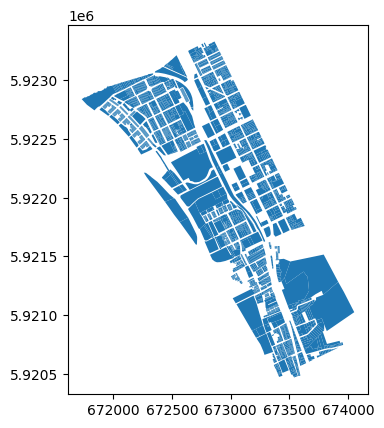

In [23]:
gdf = gpd.read_parquet('/app/assets/land_uses/actual.parquet')
gdf.plot()

In [24]:
# Función para obtener hexágonos H3 dentro de un polígono
def obtener_hexagonos_en_gdf(poligono, resolucion, expansion=0.002):
    # Expande el polígono ligeramente para asegurar cobertura completa
    poligono_expandido = poligono.buffer(expansion)
    
    # Convertir el polígono expandido a un formato que h3.polyfill pueda entender
    contorno_expandido = mapping(poligono_expandido)['coordinates'][0]
    contorno_expandido = [(y, x) for x, y in contorno_expandido]  # Asegúrate de que las coordenadas estén en formato (lat, lon)
    
    # Obtener los hexágonos usando el contorno del polígono expandido
    hexagonos = h3.polyfill_geojson({"type": "Polygon", "coordinates": [contorno_expandido]}, resolucion)
    
    return list(hexagonos)

# Función para convertir un código H3 a un objeto Polygon de Shapely, modificada para devolver también el código H3
def h3_to_polygon(hex_code):
    # Obtener los límites del hexágono como una lista de coordenadas (lat, lon)
    boundary = h3.h3_to_geo_boundary(hex_code, geo_json=True)
    # Invertir las coordenadas para cada punto del límite
    boundary_inverted = [(lon, lat) for lat, lon in boundary]
    # Crear y retornar un objeto Polygon usando estas coordenadas invertidas
    return Polygon(boundary_inverted), hex_code

def get_h3_set(gdf, resolucion):
    gdf['geometry'] = gdf['geometry'].apply(lambda poly: Polygon([(x, y) for x, y, z in poly.exterior.coords]))
    original_crs = gdf.crs
    # Suponiendo que ya has corregido la geometría de 'gdf' para que solo contenga coordenadas x, y
    # Aplicar la función al polígono en tu GeoDataFrame para obtener los hexágonos

    gdf = gdf.to_crs(4326)
    # gdf = gdf.to_crs(original_crs)
    gdf['hexagonos_h3'] = gdf['geometry'].apply(lambda poly: obtener_hexagonos_en_gdf(poly, resolucion))

    # gdf = gdf.to_crs(original_crs)
    # Suponiendo que 'hexagonos_h3' es una lista de códigos H3 obtenidos previamente y 'resolucion' es conocida
    hexagonos_h3 = gdf['hexagonos_h3'].explode().tolist()  # Aplanamos la lista si es necesario

    # Convertir cada código H3 a un Polygon y mantener el código H3
    poligonos_y_codigos = [h3_to_polygon(hex_code) for hex_code in hexagonos_h3]

    # Separar los polígonos y los códigos H3 en listas separadas
    poligonos, codigos_h3 = zip(*poligonos_y_codigos)

    # Crear un DataFrame con los códigos H3 y la resolución, luego convertirlo a GeoDataFrame
    df_hexagonos = pd.DataFrame({
        'geometry': poligonos,
        'resolucion': [resolucion] * len(codigos_h3),
        'hex_id': codigos_h3
    })
    gdf_hexagonos = gpd.GeoDataFrame(df_hexagonos, geometry='geometry')
    # gdf_hexagonos = gdf_hexagonos.set_crs(original_crs)

    overlay_hexs = gpd.overlay(gdf_hexagonos, gdf)
    filters_hexs = gdf_hexagonos[gdf_hexagonos['hex_id'].isin(overlay_hexs['hex_id'])]

    overlay_hexs = overlay_hexs.set_crs(4326)
    filters_hexs = filters_hexs.set_crs(4326)
    # import matplotlib.pyplot as plt
    # fig, ax = plt.subplots()
    # # Ahora puedes visualizar los hexágonos usando GeoPandas y también tienes las columnas 'resolucion' y 'hex_id'
    # gdf.plot(ax=ax)
    # gdf_hexagonos.plot(ax=ax,edgecolor=None, color='red', alpha=0.5)
    # gdf.to_crs(4326).plot(ax=ax)
    # Muestra las primeras filas para verificar
    # display(gdf_hexagonos.head())
    # display(gdf.head())
    # display(gpd.overlay(gdf_hexagonos, gdf))
    # filters_hexs.plot(ax=ax)
    # overlay_hexs.plot(ax=ax, color='yellow')
    return overlay_hexs, filters_hexs

In [25]:
area = gpd.read_parquet(f'{assets}/area_scope/area_scope.parquet')
# resolucion = 10
# overlay_hexs, filters_hexs = get_h3_set(area.copy(), resolucion)
# total_hexs = overlay_hexs.shape[0]

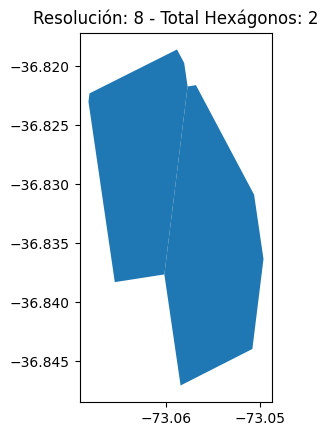

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Definamos los valores de inicio y fin
start = 8  # Valor de inicio
stop = 11  # Valor de fin (el array incluirá números hasta stop-1)

# Generar el array de números enteros
resoluciones = list(range(start, stop + 1))

fig, ax = plt.subplots()

def update(frame):
    ax.clear()  # Limpia el gráfico anterior
    resolucion = resoluciones[frame]
    # print(resolucion)
    try:
        overlay_hexs, filters_hexs = get_h3_set(area.copy(), resolucion)
        total_hexs = overlay_hexs.shape[0]
        
        # Asumiendo que overlay_hexs es un GeoDataFrame que quieres plotear
        overlay_hexs.plot(ax=ax)
        
        # Establecer título con el número total de hexágonos
        ax.set_title(f"Resolución: {resolucion} - Total Hexágonos: {total_hexs}")
    except:
        ax.set_title(f"Resolución: {resolucion} - Error")

# Crear animación
ani = FuncAnimation(fig, update, frames=range(len(resoluciones)), repeat=False)

# Guardar la animación como un gif
ani.save('/app/data/map_animation_v2.gif', writer='imagemagick', fps=2)  # Ajusta fps según necesidad

# plt.show()  # Mostrar el gráfico si deseas verlo además de guardar el GIF

In [27]:
resolucion = 12
overlay_hexs, filters_hexs = get_h3_set(area.copy(), resolucion)
overlay_hexs = overlay_hexs.to_crs(area.crs)

overlay_land_uses = gpd.overlay(overlay_hexs, gdf)

In [28]:
diversity_columns = ['Id', 'hex_id', 'Uso', 'area_predio', 'geometry']
overlay_land_uses = overlay_land_uses[diversity_columns]

In [29]:
overlay_land_uses['area_uso'] = overlay_land_uses['geometry'].area

In [30]:
hex_area_uso = overlay_land_uses[['hex_id', 'Uso', 'area_uso']].groupby(['hex_id', 'Uso']).agg('sum').reset_index()
hex_area_total = overlay_land_uses[['hex_id', 'area_uso']].groupby(['hex_id']).agg('sum').reset_index().rename(columns={'area_uso': 'total_uso'})

In [31]:
hex_area = pd.merge(hex_area_total, hex_area_uso, on='hex_id')

In [32]:
hex_area['porcion_uso'] = hex_area['area_uso']/hex_area['total_uso']

In [33]:
import numpy as np
hex_area['informacion_uso'] = -1*hex_area['porcion_uso']*np.log2(hex_area['porcion_uso'])
neg_filter = hex_area['informacion_uso'] < 0.000001
hex_area.loc[neg_filter, 'informacion_uso'] = 0

In [34]:
diversity = hex_area[['hex_id', 'informacion_uso']].groupby('hex_id').agg('sum').reset_index().rename(columns={'informacion_uso': 'diversity'})

<Axes: >

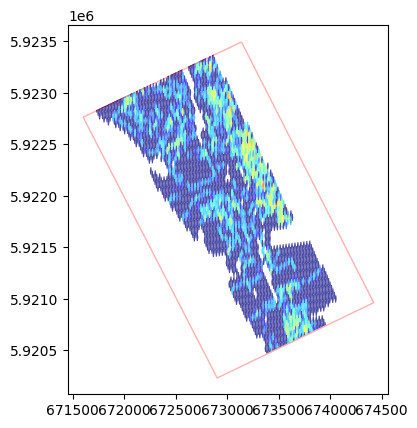

In [35]:
# base_hex = filters_hexs.copy()
base_hex = overlay_hexs.copy()

gdf_diversity = pd.merge(base_hex, diversity, on='hex_id')
# gdf_diversity = pd.concat([gdf_diversity, base_hex[~base_hex['hex_id'].isin(gdf_diversity['hex_id'])]])
gdf_diversity = gpd.GeoDataFrame(gdf_diversity, geometry=gdf_diversity['geometry'])
gdf_diversity.fillna(0, inplace=True)
gdf_diversity = gdf_diversity.to_crs(area.crs)

fig, ax = plt.subplots()
gdf_diversity.plot(column='diversity', ax=ax, colormap='jet', vmin=0, vmax=3)
area.plot(ax=ax, edgecolor='red', alpha=0.3, color='white')

In [36]:
import geohash
import shapely
from shapely.geometry import Polygon, mapping

def obtener_geohashes_expandidos(poligono, precision, expansion=0.0005):
    # Expande el polígono ligeramente para asegurar cobertura completa
    poligono_expandido = poligono.buffer(expansion)
    
    # Convertir el polígono expandido a un formato GeoJSON
    geojson_expandido = mapping(poligono_expandido)
    
    # Calcular el bounding box del polígono expandido
    min_x, min_y, max_x, max_y = poligono_expandido.bounds
    
    # Calcular geohashes iniciales que cubren el bounding box
    hash_suroeste = geohash.encode(min_y, min_x, precision)
    hash_noreste = geohash.encode(max_y, max_x, precision)
    
    # Encuentra geohashes vecinos para cubrir completamente el área
    geohashes = set()
    geohashes.add(hash_suroeste)
    
    current_hash = hash_suroeste
    while current_hash != hash_noreste:
        # Añadir vecinos al este y norte
        vecinos = geohash.neighbors(current_hash)
        vecino_este = vecinos[2]  # Este
        vecino_norte = vecinos[1]  # Norte
        
        geohashes.add(vecino_este)
        geohashes.add(vecino_norte)
        
        # Moverse diagonalmente hacia el noreste para el siguiente ciclo
        current_hash = geohash.encode(
            geohash.decode(vecino_norte)[0],  # Latitud del vecino norte
            geohash.decode(vecino_este)[1],   # Longitud del vecino este
            precision
        )
    
    # Filtrar geohashes por aquellos dentro del polígono
    geohashes_dentro = [
        g for g in geohashes
        if poligono.contains(shapely.geometry.Point(geohash.decode(g)))
    ]
    
    return geohashes_dentro

In [37]:
import shapely.geometry as geometry

def geohash_a_polygon(codigo_geohash):
    # Obtener el bounding box del geohash y convertirlo en un polígono
    puntos_geohash = geohash.bbox(codigo_geohash)
    poligono_geohash = Polygon([
        (puntos_geohash['w'], puntos_geohash['s']),
        (puntos_geohash['w'], puntos_geohash['n']),
        (puntos_geohash['e'], puntos_geohash['n']),
        (puntos_geohash['e'], puntos_geohash['s']),
        (puntos_geohash['w'], puntos_geohash['s'])
    ])
    return poligono_geohash

def geohash_a_gdf(codigo_geohash):
    poligono_geohash = geohash_a_polygon(codigo_geohash)
    # Crear un GeoDataFrame con el código geohash y el polígono
    geodf = gpd.GeoDataFrame({'geohash': [codigo_geohash], 'geometry': [poligono_geohash]})
    geodf = geodf.set_crs(4326)
    return geodf

def punto_a_geodf(x, y, precision=6):
    """
    Convierte un punto dado por coordenadas (x, y) en un GeoDataFrame que incluye
    el código geohash del punto y el polígono correspondiente al geohash.
    
    Parámetros:
    - x: Longitud del punto.
    - y: Latitud del punto.
    - precision: Precisión del geohash (número de caracteres del geohash).
    
    Retorna:
    - GeoDataFrame con dos columnas: 'geohash' y 'geometry', donde 'geometry'
      contiene el polígono correspondiente al geohash.
    """
    # Calcular el geohash para el punto dado
    codigo_geohash = geohash.encode(y, x, precision)
    
    geodf = geohash_a_gdf(codigo_geohash)
    
    return geodf

63kn3qx


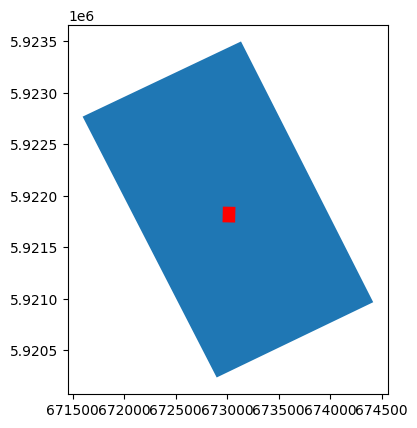

In [63]:
gdf_input = area.copy()

gdf_input = gdf_input.to_crs(4326)
gdf_input['centroid'] = gdf_input['geometry'].centroid

centroide_lat, centroide_lon = gdf_input['centroid'][0].y, gdf_input['centroid'][0].x
precision = 7
geodf_with_hash = punto_a_geodf(x=centroide_lon, y=centroide_lat, precision=precision)
fig, ax = plt.subplots()
area.plot(ax=ax)
geodf_with_hash.to_crs(area.crs).plot(ax=ax, color='red')
# display(geodf_with_hash)
codigo_geohash = geodf_with_hash['geohash'][0]
print(codigo_geohash)

In [54]:
import geopandas as gpd
import geohash
from shapely.geometry import Polygon

def expandir_geohash_centroide_niveles(codigo_geohash, niveles=1):
    """
    Expande desde un geohash central para cubrir un área cuadrada alrededor del
    centroide utilizando geohashes adyacentes a múltiples niveles.
    
    Parámetros:
    - codigo_geohash: Código geohash del centroide.
    - niveles: Número de niveles de vecinos a expandir.
    
    Retorna:
    - GeoDataFrame con las columnas 'geohash' y 'geometry', donde 'geometry'
      contiene los polígonos correspondientes a los geohashes.
    """
    
    def obtener_vecinos(ghash):
        """Obtiene todos los vecinos directos de un geohash dado."""
        return geohash.neighbors(ghash)
    
    # Inicializar la lista de geohashes con el central
    geohashes = {codigo_geohash}
    geohashes_procesar = {codigo_geohash}
    
    for _ in range(niveles):
        nuevos_geohashes = set()
        for ghash in geohashes_procesar:
            vecinos = obtener_vecinos(ghash)
            nuevos_geohashes.update(vecinos)
        geohashes_procesar = nuevos_geohashes - geohashes  # Procesar solo nuevos geohashes
        geohashes.update(nuevos_geohashes)
    
    # Crear polígonos para cada geohash y agregarlos a una lista
    poligonos = []
    for gh in geohashes:
        puntos = geohash.bbox(gh)
        poligono = Polygon([
            (puntos['w'], puntos['s']),
            (puntos['w'], puntos['n']),
            (puntos['e'], puntos['n']),
            (puntos['e'], puntos['s']),
            (puntos['w'], puntos['s'])
        ])
        poligonos.append(poligono)
    
    # Crear GeoDataFrame
    geodf = gpd.GeoDataFrame({'geohash': list(geohashes), 'geometry': poligonos})
    geodf = geodf.set_crs("EPSG:4326")
    
    return geodf

102
303


<Axes: >

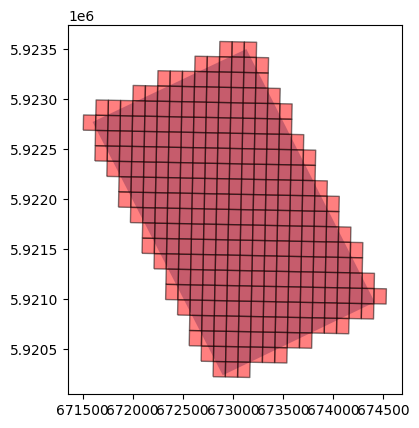

In [105]:
def get_geohash_set(area, precision, step):
    gdf_input = area.copy()
    gdf_input = gdf_input.to_crs(4326)
    gdf_input['centroid'] = gdf_input['geometry'].centroid
    area_interes = gdf_input['geometry'][0].area

    centroide_lat, centroide_lon = gdf_input['centroid'][0].y, gdf_input['centroid'][0].x
    geodf_with_hash = punto_a_geodf(x=centroide_lon, y=centroide_lat, precision=precision)
    codigo_geohash = geodf_with_hash['geohash'][0]
    niveles = 2

    while(True):
        extended_geohash = expandir_geohash_centroide_niveles(codigo_geohash, niveles=niveles)
        extended_geohash = extended_geohash.to_crs(gdf_input.crs)
        overlay_geohash = gpd.overlay(gdf_input, extended_geohash)
        overlay_area = overlay_geohash['geometry'].area.sum()
        if(overlay_area < area_interes):
            niveles += step
        else:
            break
        # print(overlay_geohash.shape[0])
    return_geohash = gpd.sjoin(extended_geohash, gdf_input)
    return_geohash = return_geohash.to_crs(4326)
    return return_geohash, niveles

testing, niveles = get_geohash_set(area, precision=7, step=100)
print(niveles)
print(testing.shape[0])
fig, ax = plt.subplots()
area.plot(ax=ax, alpha=0.5)
testing.to_crs(area.crs).plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
# display(expandir_geohash_centroide_niveles('63kn3q',niveles=niveles))

In [128]:
precision = 8
step = 100
geohashes, _ = get_geohash_set(area, precision=precision, step=step)
geohashes = geohashes.to_crs(area.crs)

overlay_gh_land_uses = gpd.overlay(geohashes, gdf)

In [129]:
diversity_columns = ['geohash', 'Uso', 'area_predio', 'geometry']

overlay_gh_land_uses = overlay_gh_land_uses[diversity_columns]

In [130]:
overlay_gh_land_uses['area_uso'] = overlay_gh_land_uses['geometry'].area

In [131]:
gh_area_uso = overlay_gh_land_uses[['geohash', 'Uso', 'area_uso']].groupby(['geohash', 'Uso']).agg('sum').reset_index()
gh_area_total = overlay_gh_land_uses[['geohash', 'area_uso']].groupby(['geohash']).agg('sum').reset_index().rename(columns={'area_uso': 'total_uso'})

In [132]:
gh_area = pd.merge(gh_area_total, gh_area_uso, on='geohash')

In [133]:
gh_area['porcion_uso'] = gh_area['area_uso']/gh_area['total_uso']

In [134]:
import numpy as np
gh_area['informacion_uso'] = -1*gh_area['porcion_uso']*np.log2(gh_area['porcion_uso'])
neg_filter = gh_area['informacion_uso'] < 0.000001
gh_area.loc[neg_filter, 'informacion_uso'] = 0

In [135]:
diversity = gh_area[['geohash', 'informacion_uso']].groupby('geohash').agg('sum').reset_index().rename(columns={'informacion_uso': 'diversity'})

<Axes: >

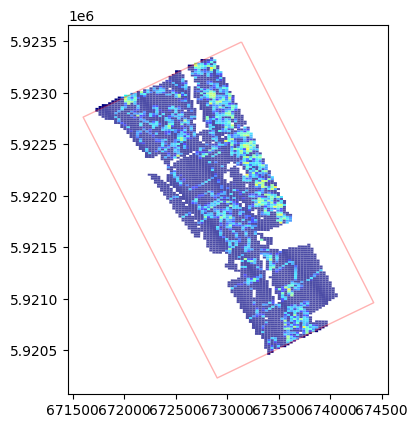

In [136]:
# base_hex = filters_hexs.copy()
base_gh = geohashes.copy()

gdf_diversity = pd.merge(base_gh, diversity, on='geohash')
# gdf_diversity = pd.concat([gdf_diversity, base_hex[~base_hex['hex_id'].isin(gdf_diversity['hex_id'])]])
gdf_diversity = gpd.GeoDataFrame(gdf_diversity, geometry=gdf_diversity['geometry'])
gdf_diversity.fillna(0, inplace=True)
gdf_diversity = gdf_diversity.to_crs(area.crs)

fig, ax = plt.subplots()
gdf_diversity.plot(column='diversity', ax=ax, colormap='jet', vmin=0, vmax=3)
area.plot(ax=ax, edgecolor='red', alpha=0.3, color='white')